<a href="https://colab.research.google.com/github/Rockeydey/Car-Price-Prediction/blob/main/Case_Study_2_Predicting_Customer_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Package

In [1]:
# !pip install chardet
# !pip install imblearn

# Import Library

In [2]:
import pandas as pd
import numpy as np

# Detect the encoding CSV files
import chardet

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For missing value imputation
from sklearn.impute import SimpleImputer


# For clustering
from sklearn.cluster import KMeans


# For train test split
from sklearn.model_selection import train_test_split

# For imbalance target class correction
from imblearn.over_sampling import RandomOverSampler

# For model building
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.ensemble import RUSBoostClassifier

# For evaluation
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score


# Import Data

In [3]:
telecom_customer_churn_encoding = chardet.detect(open("/content/drive/MyDrive/dataset/telecom_customer_churn.csv", "rb").read())["encoding"]
telecom_data_dictionary_encoding = chardet.detect(open("/content/drive/MyDrive/dataset/telecom_data_dictionary.csv", "rb").read())["encoding"]
telecom_zipcode_population_encoding = chardet.detect(open("/content/drive/MyDrive/dataset/telecom_zipcode_population.csv", "rb").read())["encoding"]

In [4]:
telecom_customer_churn = pd.read_csv("/content/drive/MyDrive/dataset/telecom_customer_churn.csv", encoding=telecom_customer_churn_encoding)
telecom_data_dictionary = pd.read_csv("/content/drive/MyDrive/dataset/telecom_data_dictionary.csv", encoding=telecom_data_dictionary_encoding)
telecom_zipcode_population = pd.read_csv("/content/drive/MyDrive/dataset/telecom_zipcode_population.csv", encoding=telecom_zipcode_population_encoding)

# Exploratory Data Analysis

## summarise data

In [5]:
print("\n Telecom_customer_churn: \n", telecom_customer_churn.head())
print("\n Telecom_data_dictionary: \n", telecom_data_dictionary.head())
print("\n Telecom_zipcode_population: \n", telecom_zipcode_population.head())
print("\n Telecom_customer_churn shape: ", telecom_customer_churn.shape)
print("\n Telecom_data_dictionary shape: ", telecom_data_dictionary.shape)
print("\n Telecom_zipcode_population shape: ", telecom_zipcode_population.shape)



 Telecom_customer_churn: 
   Customer ID  Gender  Age Married  Number of Dependents          City  \
0  0002-ORFBO  Female   37     Yes                     0  Frazier Park   
1  0003-MKNFE    Male   46      No                     0      Glendale   
2  0004-TLHLJ    Male   50      No                     0    Costa Mesa   
3  0011-IGKFF    Male   78     Yes                     0      Martinez   
4  0013-EXCHZ  Female   75     Yes                     0     Camarillo   

   Zip Code   Latitude   Longitude  Number of Referrals  ...   Payment Method  \
0     93225  34.827662 -118.999073                    2  ...      Credit Card   
1     91206  34.162515 -118.203869                    0  ...      Credit Card   
2     92627  33.645672 -117.922613                    0  ...  Bank Withdrawal   
3     94553  38.014457 -122.115432                    1  ...  Bank Withdrawal   
4     93010  34.227846 -119.079903                    3  ...      Credit Card   

  Monthly Charge Total Charges  Total Re

In [6]:
#Get population in churn data
df = pd.merge(telecom_customer_churn, telecom_zipcode_population, on='Zip Code', how='left')

In [7]:
print(df.columns, "\n ",df.shape)

Index(['Customer ID', 'Gender', 'Age', 'Married', 'Number of Dependents',
       'City', 'Zip Code', 'Latitude', 'Longitude', 'Number of Referrals',
       'Tenure in Months', 'Offer', 'Phone Service',
       'Avg Monthly Long Distance Charges', 'Multiple Lines',
       'Internet Service', 'Internet Type', 'Avg Monthly GB Download',
       'Online Security', 'Online Backup', 'Device Protection Plan',
       'Premium Tech Support', 'Streaming TV', 'Streaming Movies',
       'Streaming Music', 'Unlimited Data', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charge', 'Total Charges', 'Total Refunds',
       'Total Extra Data Charges', 'Total Long Distance Charges',
       'Total Revenue', 'Customer Status', 'Churn Category', 'Churn Reason',
       'Population'],
      dtype='object') 
  (7043, 39)


In [8]:
# Drop columns which has all unique values
df = df.loc[:, (df.nunique() != len(df))]

## Defining target variable, numerical, categorical variables

In [9]:
# Target variable
target_variable_name =["Customer Status"]
print("target_variable_name :",target_variable_name )

target_variable_name : ['Customer Status']


In [10]:
# Numerical variable
numerical_variable_name = [
    col for col in df.columns
    if df[col].dtype != 'object' and col !='Zip Code' and col !='Latitude'and col !='Longitude' and col !='Age'
]
print ("numerical variables:",numerical_variable_name)

numerical variables: ['Number of Dependents', 'Number of Referrals', 'Tenure in Months', 'Avg Monthly Long Distance Charges', 'Avg Monthly GB Download', 'Monthly Charge', 'Total Charges', 'Total Refunds', 'Total Extra Data Charges', 'Total Long Distance Charges', 'Total Revenue', 'Population']


In [11]:
# Categorical variable
categorical_variable_name = [
    col for col in df.columns
    if col != "Customer Status" and col not in numerical_variable_name
]

print("Categorical variables:", categorical_variable_name)

Categorical variables: ['Gender', 'Age', 'Married', 'City', 'Zip Code', 'Latitude', 'Longitude', 'Offer', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Internet Type', 'Online Security', 'Online Backup', 'Device Protection Plan', 'Premium Tech Support', 'Streaming TV', 'Streaming Movies', 'Streaming Music', 'Unlimited Data', 'Contract', 'Paperless Billing', 'Payment Method', 'Churn Category', 'Churn Reason']


## Descriptive statistics for numerical columns


In [12]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,7043.0,46.509726,16.750352,19.000000,32.000000,46.000000,60.000000,80.000000
Number of Dependents,7043.0,0.468692,0.962802,0.000000,0.000000,0.000000,0.000000,9.000000
Zip Code,7043.0,93486.070567,1856.767505,90001.000000,92101.000000,93518.000000,95329.000000,96150.000000
Latitude,7043.0,36.197455,2.468929,32.555828,33.990646,36.205465,38.161321,41.962127
Longitude,7043.0,-119.756684,2.154425,-124.301372,-121.788090,-119.595293,-117.969795,-114.192901
Number of Referrals,7043.0,1.951867,3.001199,0.000000,0.000000,0.000000,3.000000,11.000000
Tenure in Months,7043.0,32.386767,24.542061,1.000000,9.000000,29.000000,55.000000,72.000000
Avg Monthly Long Distance Charges,6361.0,25.420517,14.200374,1.010000,13.050000,25.690000,37.680000,49.990000
Avg Monthly GB Download,5517.0,26.189958,19.586585,2.000000,13.000000,21.000000,30.000000,85.000000
Monthly Charge,7043.0,63.596131,31.204743,-10.000000,30.400000,70.050000,89.750000,118.750000


## Frequency counts for Target variable

In [13]:
df['Customer Status'].value_counts()

Stayed     4720
Churned    1869
Joined      454
Name: Customer Status, dtype: int64

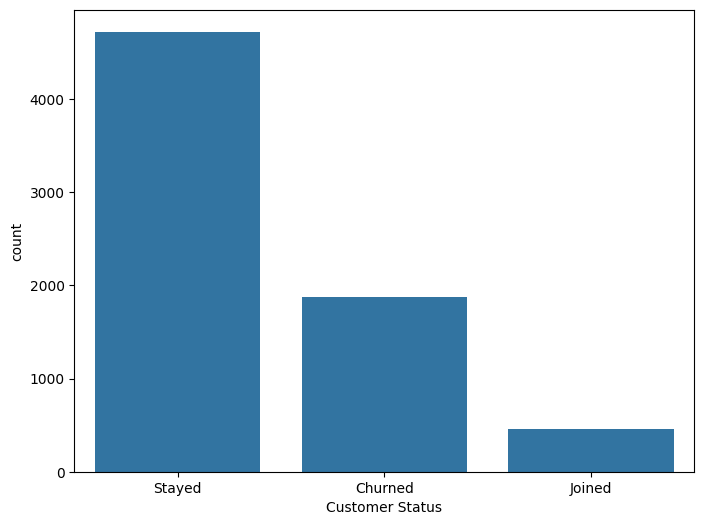

In [14]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Customer Status', data=df)
plt.show()

## Age Vs churned

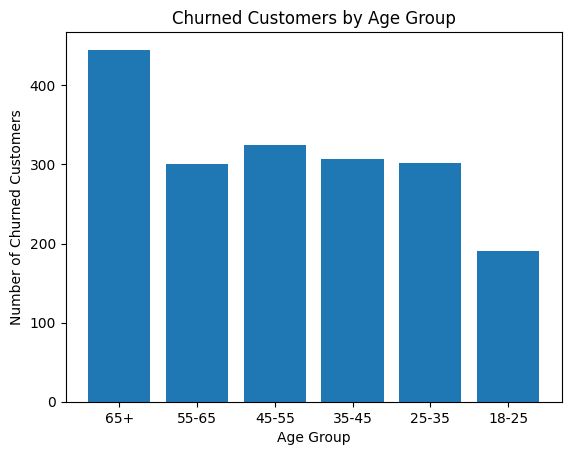

In [15]:
age_group = pd.cut(df['Age'], bins=[18, 25, 35, 45, 55, 65, np.inf], labels=['18-25', '25-35', '35-45', '45-55', '55-65', '65+'])
churned = df[df['Customer Status'] == 'Churned']
churned_age_group = pd.cut(churned['Age'], bins=[18, 25, 35, 45, 55, 65, np.inf], labels=['18-25', '25-35', '35-45', '45-55', '55-65', '65+'])
churned_age_group_counts = churned_age_group.value_counts().sort_index(ascending=False)
plt.bar(churned_age_group_counts.index, churned_age_group_counts.values)
plt.xlabel('Age Group')
plt.ylabel('Number of Churned Customers')
plt.title('Churned Customers by Age Group')
plt.show()


In [16]:
df.columns

Index(['Gender', 'Age', 'Married', 'Number of Dependents', 'City', 'Zip Code',
       'Latitude', 'Longitude', 'Number of Referrals', 'Tenure in Months',
       'Offer', 'Phone Service', 'Avg Monthly Long Distance Charges',
       'Multiple Lines', 'Internet Service', 'Internet Type',
       'Avg Monthly GB Download', 'Online Security', 'Online Backup',
       'Device Protection Plan', 'Premium Tech Support', 'Streaming TV',
       'Streaming Movies', 'Streaming Music', 'Unlimited Data', 'Contract',
       'Paperless Billing', 'Payment Method', 'Monthly Charge',
       'Total Charges', 'Total Refunds', 'Total Extra Data Charges',
       'Total Long Distance Charges', 'Total Revenue', 'Customer Status',
       'Churn Category', 'Churn Reason', 'Population'],
      dtype='object')

## Check for missing values

In [17]:
df.isnull().sum()

Gender                                  0
Age                                     0
Married                                 0
Number of Dependents                    0
City                                    0
Zip Code                                0
Latitude                                0
Longitude                               0
Number of Referrals                     0
Tenure in Months                        0
Offer                                   0
Phone Service                           0
Avg Monthly Long Distance Charges     682
Multiple Lines                        682
Internet Service                        0
Internet Type                        1526
Avg Monthly GB Download              1526
Online Security                      1526
Online Backup                        1526
Device Protection Plan               1526
Premium Tech Support                 1526
Streaming TV                         1526
Streaming Movies                     1526
Streaming Music                   

## Check outliers

In [18]:
# List of all outliers in numerical variable

outliers = []
for col in numerical_variable_name:
  Q1 = df[col].quantile(0.25)
  Q3 = df[col].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  outlier_count = df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0]
  if outlier_count > 0:
    outliers.append(col)
print(outliers)


['Number of Dependents', 'Number of Referrals', 'Avg Monthly GB Download', 'Total Refunds', 'Total Extra Data Charges', 'Total Long Distance Charges', 'Total Revenue', 'Population']


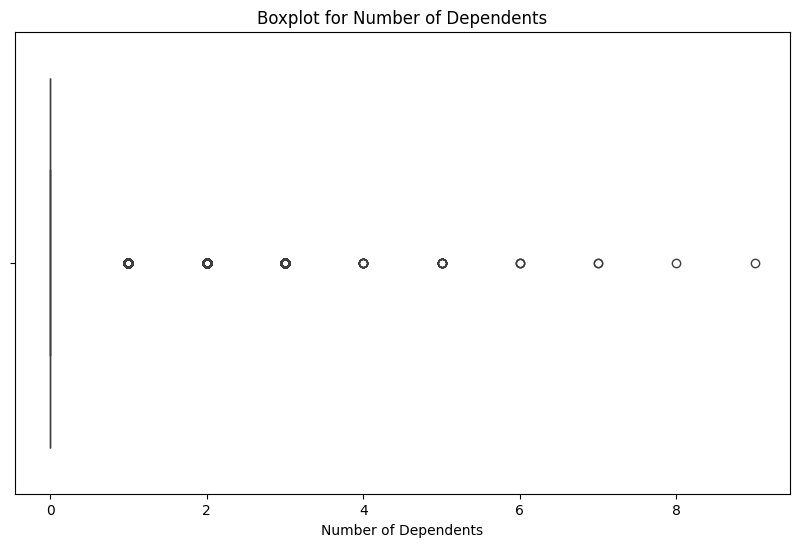

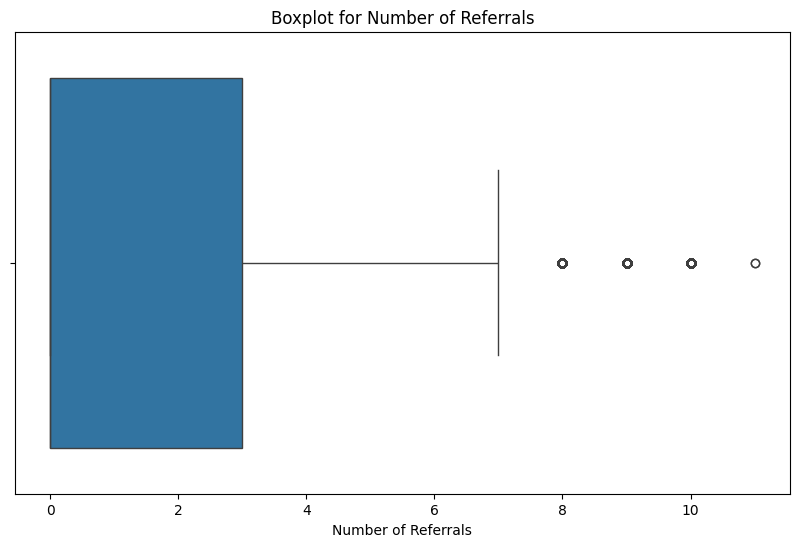

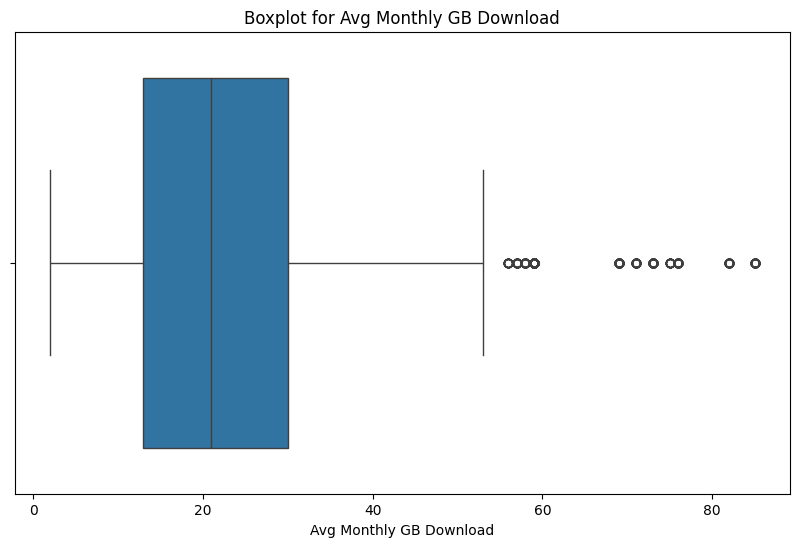

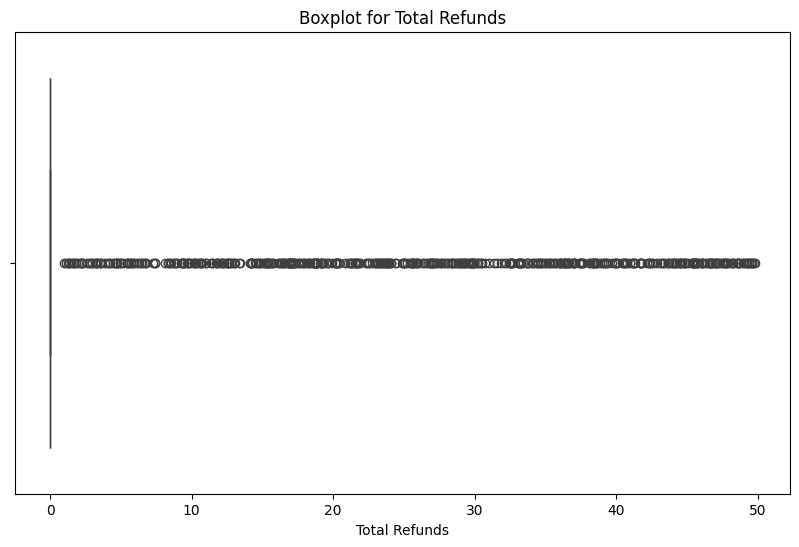

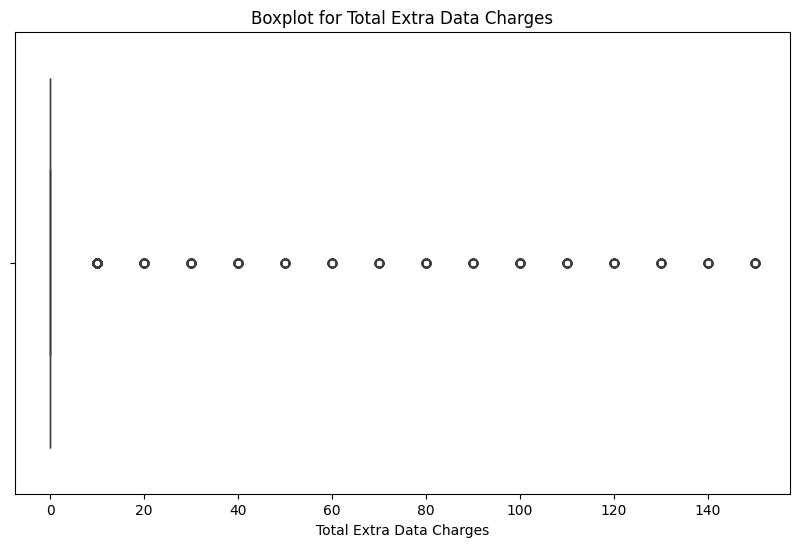

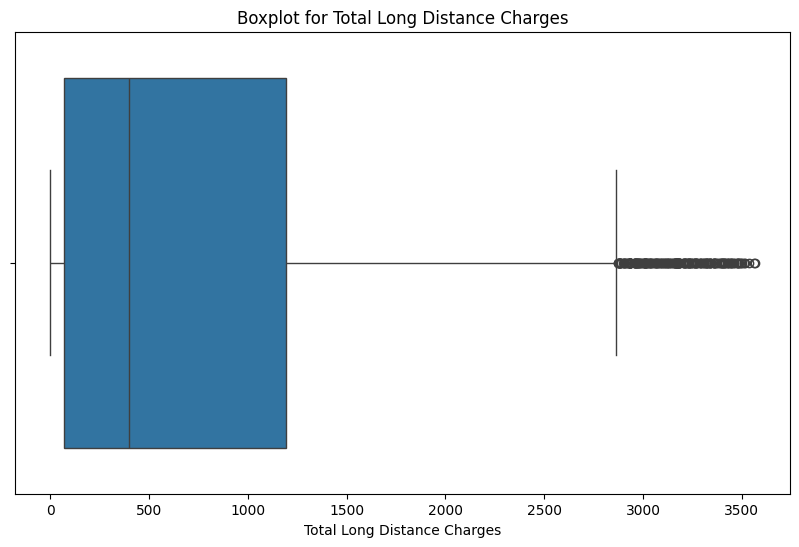

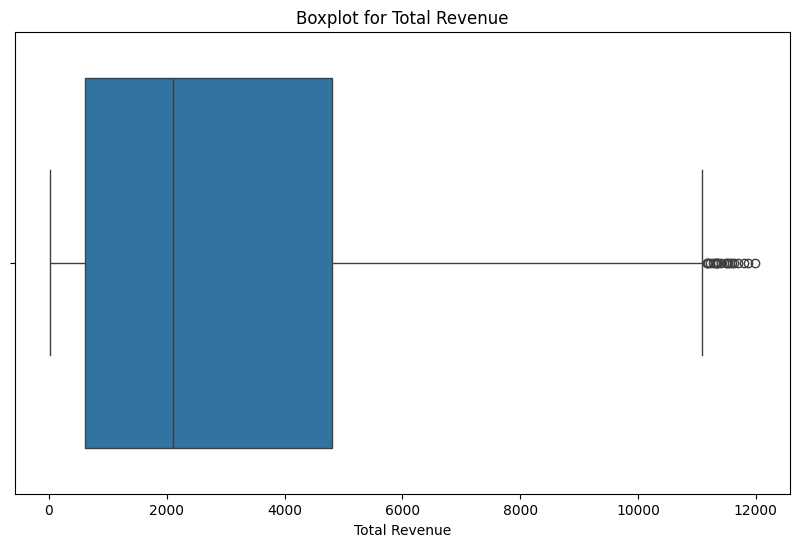

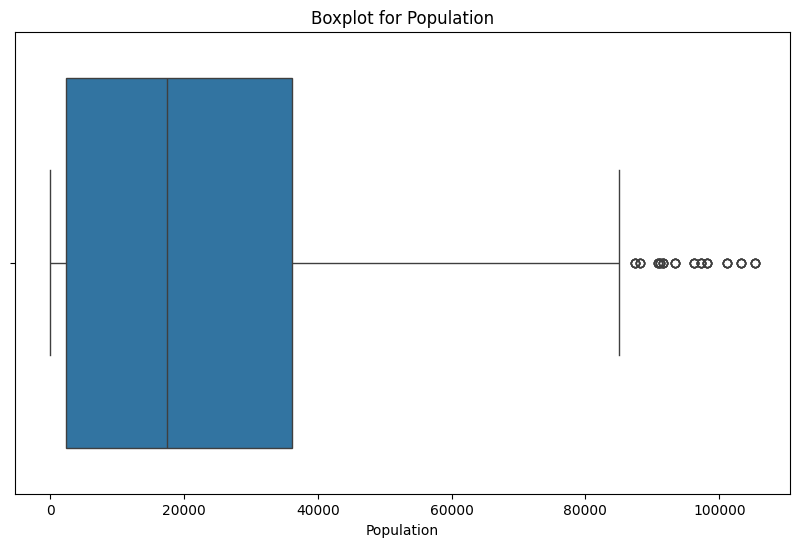

In [19]:
# Plot outliers
for col in outliers:
  plt.figure(figsize=(10, 6))
  sns.boxplot(x=col, data=df)
  plt.title(f"Boxplot for {col}")
  plt.show()


# Data Pre Processing

## Missing value imputation

In [20]:
# Missing value imputation for categorical_variable_name in df with mode

imputer = SimpleImputer(strategy="most_frequent")
for col in categorical_variable_name:
  df[col] = imputer.fit_transform(df[[col]])


In [21]:
# Missing value imputation for numerical_variable_name in df with mean
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

for col in numerical_variable_name:
  df[col] = imputer.fit_transform(df[[col]])


## Outlier treatment

In [22]:
# Outliers treamtment
for col in outliers:
  lower_bound = df[col].quantile(0.25) - 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25))
  upper_bound = df[col].quantile(0.75) + 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25))
  df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
  df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])


## Categorical variable to numerical variable

### Age variable

In [23]:
# Convert Age column to age group
df['age_group'] = pd.cut(df['Age'], bins=[18, 25, 35, 45, 55, 65, np.inf], labels=['18-25', '25-35', '35-45', '45-55', '55-65', '65+'])

### Zip Code, City, Population

In [24]:
df['Zip Code'].nunique()

1626

In [25]:
# Binning City, Zip Code & Population together
df['city_zip_pop'] = df['City'] + '_' + df['Zip Code'].astype(str)+'_'+ df['Population'].astype(str)

### Location based segmentation

Latitude and longitude based clustering

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


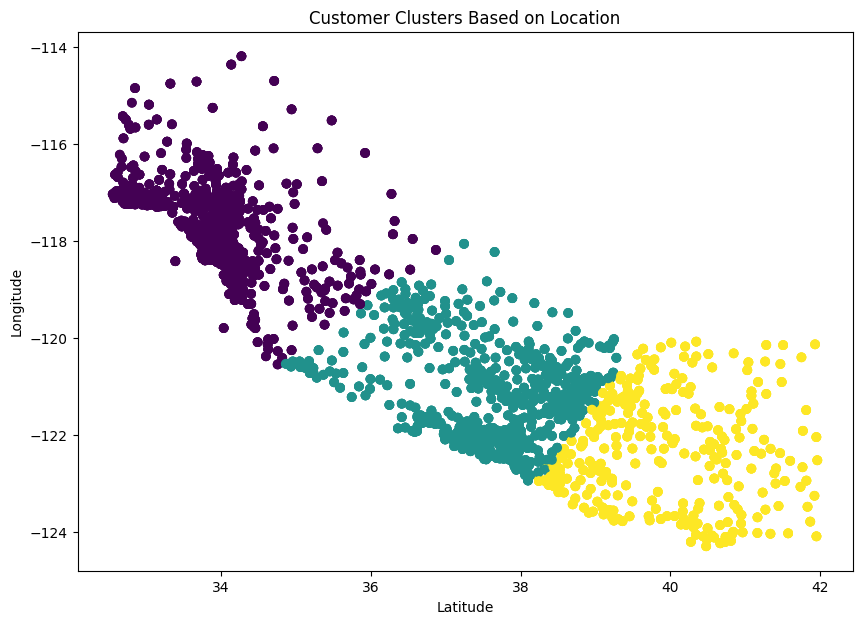

In [26]:
# Extract latitude and longitude
latitude = df['Latitude']
longitude = df['Longitude']

# Define number of clusters
num_clusters = 3

# Create KMeans model
kmeans = KMeans(n_clusters=num_clusters)

# Fit the model to the data
kmeans.fit(df[['Latitude', 'Longitude']])

# Add cluster labels to the dataframe
df['cluster_label'] = kmeans.labels_

# Plot the clusters
plt.figure(figsize=(10, 7))
plt.scatter(df['Latitude'], df['Longitude'], c=df['cluster_label'], cmap='viridis')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Customer Clusters Based on Location')
plt.show()


In [27]:
categorical_variable_name.append('city_zip_pop')
categorical_variable_name.append('age_group')


### Label encoding categorical variable

In [28]:
# Convert categorical variable into numerical
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in categorical_variable_name:
  if col not in ['Latitude', 'Longitude']:
    df[col] = le.fit_transform(df[col])
# Convert target variable into numerical
df['Customer Status'] = le.fit_transform(df['Customer Status'])


### updated categorical variable list

In [29]:
df.columns

Index(['Gender', 'Age', 'Married', 'Number of Dependents', 'City', 'Zip Code',
       'Latitude', 'Longitude', 'Number of Referrals', 'Tenure in Months',
       'Offer', 'Phone Service', 'Avg Monthly Long Distance Charges',
       'Multiple Lines', 'Internet Service', 'Internet Type',
       'Avg Monthly GB Download', 'Online Security', 'Online Backup',
       'Device Protection Plan', 'Premium Tech Support', 'Streaming TV',
       'Streaming Movies', 'Streaming Music', 'Unlimited Data', 'Contract',
       'Paperless Billing', 'Payment Method', 'Monthly Charge',
       'Total Charges', 'Total Refunds', 'Total Extra Data Charges',
       'Total Long Distance Charges', 'Total Revenue', 'Customer Status',
       'Churn Category', 'Churn Reason', 'Population', 'age_group',
       'city_zip_pop', 'cluster_label'],
      dtype='object')

In [30]:
items_to_remove = ['City', 'Zip Code','Population','Age','Latitude','Longitude']
categorical_variable_name=[item for item in categorical_variable_name if item not in items_to_remove]
categorical_variable_name.append('cluster_label')
categorical_variable_name

['Gender',
 'Married',
 'Offer',
 'Phone Service',
 'Multiple Lines',
 'Internet Service',
 'Internet Type',
 'Online Security',
 'Online Backup',
 'Device Protection Plan',
 'Premium Tech Support',
 'Streaming TV',
 'Streaming Movies',
 'Streaming Music',
 'Unlimited Data',
 'Contract',
 'Paperless Billing',
 'Payment Method',
 'Churn Category',
 'Churn Reason',
 'city_zip_pop',
 'age_group',
 'cluster_label']

In [31]:
df[categorical_variable_name].dtypes

Gender                    int64
Married                   int64
Offer                     int64
Phone Service             int64
Multiple Lines            int64
Internet Service          int64
Internet Type             int64
Online Security           int64
Online Backup             int64
Device Protection Plan    int64
Premium Tech Support      int64
Streaming TV              int64
Streaming Movies          int64
Streaming Music           int64
Unlimited Data            int64
Contract                  int64
Paperless Billing         int64
Payment Method            int64
Churn Category            int64
Churn Reason              int64
city_zip_pop              int64
age_group                 int64
cluster_label             int32
dtype: object

# Creating data subset based on cluster

In [32]:
# Clean data together
df = pd.concat([df[numerical_variable_name], df[categorical_variable_name], df[target_variable_name]], axis=1)


In [33]:
#Cluster 0 subset
df_0 = df[df['cluster_label'] == 0]
df_0=df_0.drop('cluster_label', axis=1)
#Cluster 1 subset
df_1 = df[df['cluster_label'] == 1]
df_1=df_1.drop('cluster_label', axis=1)
#Cluster 0 subset
df_2 = df[df['cluster_label'] == 2]
df_2=df_2.drop('cluster_label', axis=1)

In [34]:
df_0.shape

(3399, 35)

In [35]:
df_0.dtypes

Number of Dependents                 float64
Number of Referrals                  float64
Tenure in Months                     float64
Avg Monthly Long Distance Charges    float64
Avg Monthly GB Download              float64
Monthly Charge                       float64
Total Charges                        float64
Total Refunds                        float64
Total Extra Data Charges             float64
Total Long Distance Charges          float64
Total Revenue                        float64
Population                           float64
Gender                                 int64
Married                                int64
Offer                                  int64
Phone Service                          int64
Multiple Lines                         int64
Internet Service                       int64
Internet Type                          int64
Online Security                        int64
Online Backup                          int64
Device Protection Plan                 int64
Premium Te

In [36]:
df_0[target_variable_name].value_counts()

Customer Status
2                  2226
0                   947
1                   226
dtype: int64

# Train Test Split

## Cluster 0

In [37]:
# Separate features and target
features = df_0.drop('Customer Status', axis=1)
target = df_0['Customer Status']

# Split the data into train and test sets
X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(features, target, test_size=0.25, random_state=42)

# Print the shapes of the train and test sets
print('X_train_0 shape:', X_train_0.shape)
print('y_train_0 shape:', y_train_0.shape)
print('X_test_0 shape:', X_test_0.shape)
print('y_test_0 shape:', y_test_0.shape)

X_train_0 shape: (2549, 34)
y_train_0 shape: (2549,)
X_test_0 shape: (850, 34)
y_test_0 shape: (850,)


In [38]:
# Define the oversampling strategy
oversampler = RandomOverSampler(sampling_strategy='all')

# Fit the oversampler to the training data
X_train_0, y_train_0 = oversampler.fit_resample(X_train_0, y_train_0)

# Print the shapes of the balanced train data
print('Balanced X_train_0 shape:', X_train_0.shape)
print('Balanced y_train_0 shape:', y_train_0.shape)


Balanced X_train_0 shape: (5145, 34)
Balanced y_train_0 shape: (5145,)


In [39]:
y_train_0.value_counts()

0    1715
2    1715
1    1715
Name: Customer Status, dtype: int64

## Cluster 1

## Cluster 2

# Feature selection

In [40]:
# get feature importance score
from sklearn.ensemble import RandomForestClassifier

# Instantiate a RandomForestClassifier
rf = RandomForestClassifier()

# Fit the model on the training set
rf.fit(X_train_0, y_train_0)

# Get the feature importances
importances = rf.feature_importances_

# Create a DataFrame of feature importances
feature_importances = pd.DataFrame({
    'feature': X_train_0.columns,
    'importance': importances
}).sort_values('importance', ascending=False)

# Print the feature importances
print(feature_importances)


                              feature  importance
31                       Churn Reason    0.225128
2                    Tenure in Months    0.153628
6                       Total Charges    0.102001
10                      Total Revenue    0.097337
30                     Churn Category    0.091026
9         Total Long Distance Charges    0.059818
27                           Contract    0.050048
5                      Monthly Charge    0.033755
1                 Number of Referrals    0.023086
32                       city_zip_pop    0.021095
11                         Population    0.019241
3   Avg Monthly Long Distance Charges    0.016639
4             Avg Monthly GB Download    0.016471
33                          age_group    0.010939
17                   Internet Service    0.008965
29                     Payment Method    0.008318
14                              Offer    0.006883
28                  Paperless Billing    0.006529
16                     Multiple Lines    0.005617


In [41]:
y_train_0.value_counts()

0    1715
2    1715
1    1715
Name: Customer Status, dtype: int64

In [42]:
#Keep top 6 feature as per feature_importances in training set
X_train_0 = X_train_0[feature_importances['feature'].head(6).to_list()]
X_test_0 = X_test_0[feature_importances['feature'].head(6).to_list()]



# Build Model

In [43]:
# Define models
models = [
    LogisticRegression(max_iter=1000),
    XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    RUSBoostClassifier(),
    EasyEnsembleClassifier(random_state=1),
]

# Define names for models
model_names = [
    "Logistic Regression",
    "XGBoost",
    "SMOTEBoost",
    "EasyEnsembleClassifier",
]

# Train and evaluate models

## Cluster 0

In [49]:
# Train and evaluate models
for model, name in zip(models, model_names):
    model.fit(X_train_0, y_train_0)
    y_pred_0 = model.predict(X_test_0)
    accuracy = accuracy_score(y_test_0, y_pred_0)
    recall = recall_score(y_test_0, y_pred_0, average='macro')
    precision = precision_score(y_test_0, y_pred_0, average='macro')
    f1 = f1_score(y_test_0, y_pred_0, average='macro')
    print(f"Model: {name}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print()

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model: Logistic Regression
Accuracy: 0.86
Recall: 0.87
Precision: 0.79
F1 Score: 0.82

Model: XGBoost
Accuracy: 0.95
Recall: 0.92
Precision: 0.93
F1 Score: 0.93

Model: SMOTEBoost
Accuracy: 0.96
Recall: 0.96
Precision: 0.94
F1 Score: 0.95

Model: EasyEnsembleClassifier
Accuracy: 0.69
Recall: 0.67
Precision: 0.40
F1 Score: 0.49



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Cluster 1

## Cluster 2

# Output based on best model on the evaluation metrics

## Cluster O

In [54]:
# Choose the best model based on the evaluation metrics
best_model_0 = RUSBoostClassifier()

# Train the best model on the entire training data
best_model_0.fit(X_train_0, y_train_0)

# Get predictions on the test data
y_pred_0 = best_model_0.predict(X_test_0)

# Print the predictions
print(y_pred_0)

[0 0 0 2 2 2 2 2 2 2 2 0 2 2 0 2 2 2 2 2 2 1 2 0 0 2 0 2 2 2 2 0 2 2 0 0 2
 0 2 0 2 0 2 0 2 2 2 0 2 2 2 0 0 2 2 2 2 2 2 2 2 0 2 0 2 2 0 2 2 2 0 0 0 1
 2 2 2 0 0 2 2 2 0 2 2 2 0 1 0 2 2 1 2 2 0 1 1 2 0 0 1 2 2 2 2 2 2 2 0 2 0
 0 2 0 2 2 2 0 2 2 0 0 2 0 2 2 0 0 2 0 0 2 0 2 2 2 2 2 0 2 2 2 2 2 2 2 1 0
 2 1 2 1 0 1 2 2 0 0 2 2 0 1 0 1 2 2 2 2 1 2 2 2 2 2 0 2 2 2 2 0 2 0 0 0 1
 2 0 1 1 2 2 0 2 2 1 2 2 2 2 2 0 2 0 2 0 2 2 1 0 1 0 2 2 2 0 0 2 2 2 2 2 0
 2 2 2 2 0 2 1 2 0 0 0 0 2 2 0 2 2 0 2 2 2 1 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 0 2 2 0 0 0 2 2 2 2 0 2 2 1 2 2 0 0 2 2 2 2 0 2 0 2 2 0 2 2
 2 2 0 0 0 2 0 2 0 2 1 2 1 2 2 0 2 2 2 0 2 2 2 2 1 2 0 0 2 0 2 2 2 2 0 0 2
 2 2 2 2 2 2 0 2 0 1 2 2 0 2 0 2 2 2 2 1 2 2 2 0 2 2 1 1 2 0 0 0 2 2 2 1 2
 2 2 0 2 2 0 0 0 2 2 2 2 0 0 1 2 2 2 0 2 2 2 1 2 2 2 2 0 1 2 0 2 0 0 0 2 2
 2 2 2 1 2 2 2 2 2 0 2 1 2 2 2 2 2 2 2 2 2 2 1 2 0 2 2 0 2 2 0 2 2 2 2 2 2
 2 2 2 2 2 0 2 2 2 0 2 1 0 2 2 2 0 2 2 2 0 2 0 2 2 2 0 0 2 2 2 0 2 2 2 2 2
 2 2 2 0 2 2 2 0 2 0 2 2 

In [57]:
# prompt: create a data frame with y_pred_0 and y_test_0 with one column matching or not

result = pd.DataFrame({'y_pred_0': y_pred_0, 'y_test_0': y_test_0, 'match': y_pred_0 == y_test_0})
print(result)


      y_pred_0  y_test_0  match
641          0         0   True
5922         0         0   True
4402         0         0   True
919          2         2   True
1021         2         2   True
...        ...       ...    ...
3462         2         2   True
4092         2         2   True
5196         1         1   True
6764         1         1   True
6715         1         1   True

[850 rows x 3 columns]


In [60]:
accuracy = accuracy_score(y_test_0, y_pred_0)
recall = recall_score(y_test_0, y_pred_0, average='macro')
precision = precision_score(y_test_0, y_pred_0, average='macro')
f1 = f1_score(y_test_0, y_pred_0, average='macro')
print(f"Model: {'SMOTEBoost'}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1 Score: {f1:.2f}")
print()

Model: SMOTEBoost
Accuracy: 0.96
Recall: 0.96
Precision: 0.94
F1 Score: 0.95



##Cluster 1

## Cluster 2